In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensornetwork as tn
import numpy as np
from pprint import pprint
from tebd import tebd
from misc import mps_2form, mps_overlap
from state_approximation import mps2mpo, mpo2mps, multiple_diagonal_expansions,\
                                diagonal_expansion, contract_diagonal_expansion,\
                                contract_series_diagonal_expansions, mpo_on_mps,\
                                entanglement_entropy
from moses_simple import moses_move as moses_move_simple
import matplotlib.pyplot as plt

In [13]:
def process_network(network, labels=None):
    """ Given a tensor network -- either an MPO or an MPS -- return a list of tn.Node
    with correct connections. 
    Parameters
    ----------
    network: List
        list of np.Array with format either pSN or WESN. 
    labels : List
        A list of str to add as labels to each node.
    """
    if type(network[0]) == tn.Node:
        return network
    tn_network = np.array([tn.Node(i) for i in network])
    L = len(network)
    if labels:
        for i in range(L):
            tn_network[i].name = str(labels[i])
    if tn_network[0].get_rank() == 3: #MPS
        for i in range(L-1):
            tn_network[i][-1] ^ tn_network[i+1][1]
    if tn_network[0].get_rank() == 4: #MPO
        for i in range(L-1):
            tn_network[i][-1] ^ tn_network[i+1][2]
    else:
        raise ValueError("Unrecognized tensor network.")
    return tn_network

def _mpo_on_mpo_straight(mpoL, mpoR):
    """ mpo on mpo, assumes inputs are lists of tensor networks with
    vertical contractions already performed """
    mpo_out = []
    L = len(mpoL)
    for i in range(L):
        mpoL[i][1] ^ mpoR[i][0]
        tensor_out = tn.contract_between(mpoL[i], mpoR[i])
        tn.flatten_edges([tensor_out[1], tensor_out[4]])
        tn.flatten_edges([tensor_out[1], tensor_out[3]])
        mpo_out.append(tensor_out)
    return mpo_out

def _mpo_on_mpo_shifted(mpoL, mpoR):
    """ mpo on mpo with the shifted protocol. Does this by contracting the
    entire tensor then using a series of qr decompositions to return to
    isometric form. 
    """
    L = len(mpoL)
    mpoL[0][1] ^ mpoR[0][2]
    for i in range(L-1):
        mpoL[i+1][1] ^ mpoR[i][0]
    mpoL[L-1][3] ^ mpoR[L-1][0]
    
    edge_list = []
    for i in range(L):
        edge_list.extend(ordered_get_all_dangling([mpoL[i], mpoR[i]]))
        
    output = tn.contractors.auto(tn.reachable(mpoL[0]), edge_list)
    out = []
    node_q, output = tn.split_node_qr(output, left_edges=output[0:3], right_edges=output[3:])
    out.append(node_q.reorder_axes([0,2,1,3]))
    for i in range(L-2):
        node_q, output = tn.split_node_qr(output, left_edges=output[:3], right_edges=output[3:])
        out.append(node_q.reorder_axes([1,2,0,3]))
    out.append(output.reorder_axes([1,2,0,3]))
    return out

def _mpo_on_mpo_shifted_efficient(mpoL, mpoR):
    """ mpo_on_mpo with the efficient shifted protocol. This should be your default.
    Only needs to do qr decompositions on the first and last tensor.
    """
    L = len(mpoL)
    mpo_out = []
    for i in range(2, L-1):
        mpoL[i][1] ^ mpoR[i-1][0]
        mpo_out.append(tn.contract_between(mpoL[i], mpoR[i-1]))
    for i in range(2,L-1):
        tn.flatten_edges([mpo_out[i-2][1], mpo_out[i-2][4]])
        tn.flatten_edges([mpo_out[i-2][1], mpo_out[i-2][3]])
    
    mpoL[1][1] ^ mpoR[0][0]
    mpoL[0][1] ^ mpoR[0][2]
    
    first_tensor = tn.contract_between(mpoL[0], mpoL[1])
    first_tensor = tn.contract_between(first_tensor, mpoR[0])
    first_tensor, second_tensor = tn.split_node_qr(first_tensor, 
                                                   left_edges=[first_tensor[0], first_tensor[1]],
                                                   right_edges=[first_tensor[i] for i in [2,4,3,5]]
                                                )
    first_shape = first_tensor.shape
    first_tensor = tn.Node(first_tensor.tensor.reshape((*first_shape, 1)))
    first_tensor = tn.transpose(first_tensor, [0,3,1,2])
    
    tn.flatten_edges([second_tensor[3], second_tensor[4]])
    second_tensor = tn.transpose(second_tensor, [1,2,0,3])
    mpo_out = [first_tensor, second_tensor] + mpo_out
    

    
    mpoL[L-1][3] ^ mpoR[L-1][0]
    mpoL[L-1][1] ^ mpoR[L-2][0]
    first_tensor = tn.contract_between(mpoL[L-1], mpoR[L-2])
    first_tensor = tn.contract_between(first_tensor, mpoR[L-1])
    first_tensor, second_tensor = tn.split_node_qr(first_tensor,
                                  left_edges=[first_tensor[i] for i in range(4)],
                                  right_edges=[first_tensor[i] for i in [4,5]])
    second_tensor = tn.flatten_edges([second_tensor[3], second_tensor[4]])
    second_tensor = tn.transpose(second_tensor, [1,2,0,3])
    mpo_out.extend([first_tensor, second_tensor])
    return(mpo_out)

def mpo_on_mpo(mpoL, mpoR, mode='shifted'):
    """ Contracts two mpos with shift for series of quantum gates. Really contracts the whole 
    tensor then splits it using a series of QRs, so may end up being quite expensive... but
    is probably the correct way to do it.
    Parameters
    ----------
    mpoL:
        Left mpo
    mpoR:
        Right mpo with leg format 
    mode:
        Contraction method. The options are straight, shifted, and shifted_efficient. The
        first is a vanilla mpo on mpo, the second is the fancy shifting we're doing, but
        we contract the whole network and reconstruct the mpo. The third only does QRs
        on the first and the last few tensors.
    """
    mpoL = process_network(mpoL.copy())
    mpoR = process_network(mpoR.copy())
    
    if mode == 'shifted':
        return _mpo_on_mpo_shifted(mpoL, mpoR)
    elif mode == 'shifted_efficient':
        return _mpo_on_mpo_shifted_efficient(mpoL, mpoR)
    elif mode == 'straight':
        return _mpo_on_mpo_straight(mpoL, mpoR)
    else:
        raise ValueError("Invalid mode")
    
def series_contraction(As, Lambda):
    output = As[0]
    for A in As[1:]:
        output = mpo_on_mpo(output, A)
    return mpo_on_mpo(output, Lambda)


def remove_dangling_legs(mps):
    """ Removes the dangling legs on an mps. """
    d1, chiL1, chiR1 = mps[0].shape
    d2, chiL2, chiR2 = mps[-1].shape
    assert chiL1 == chiR2 == 1
    mps[0] = mps[0].reshape((d1, chiR1))
    mps[-1] = mps[-1].reshape((d2, chiL2))
    return mps


In [36]:
from state_approximation import random_mps_N_unitaries

In [47]:
tebd_state, _, _ = tebd(4, 1.5, 0.1)
tebd_state = random_mps_N_unitaries(12, 13)
Psi = mps2mpo(tebd_state.copy())
Lambda = Psi.copy()
As, Lambda, Ss, fidelity, cp, Lambdas = multiple_diagonal_expansions(Psi,100)
#numpy_contraction = contract_series_diagonal_expansions(As, Lambda)
#print(mps_overlap(Psi, numpy_contraction))

applying unitary to site 0, 1
applying unitary to site 1, 2
applying unitary to site 2, 3
applying unitary to site 3, 4
applying unitary to site 4, 5
applying unitary to site 5, 6
applying unitary to site 6, 7
applying unitary to site 7, 8
applying unitary to site 8, 9
applying unitary to site 9, 10
applying unitary to site 10, 11
applying unitary to site 0, 1
applying unitary to site 1, 2


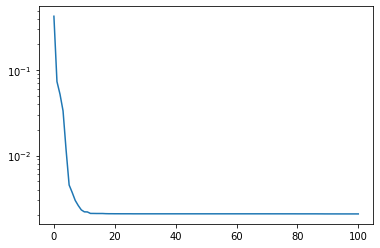

In [48]:
plt.semilogy(Ss)

In [27]:
mps_overlap(Lambdas[-1], Lambdas[-24])

0.9999992630272666

In [28]:
overlap = [np.abs(mps_overlap(Lambda, Lambdas[-1])) for Lambda in Lambdas[:-1]]

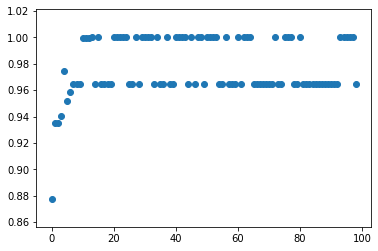

In [29]:
plt.scatter(range(len(overlap)), overlap)

In [15]:
out = mpo_on_mpo(As[0], Lambda, mode='shifted_efficient')

ValueError: Two edges do not share the same nodes. 'Dangling_3's nodes: '__unnamed_node__', '__unnamed_node__'. 'Dangling_3's nodes: '__unnamed_node__', '__unnamed_node__'

In [641]:
mps_overlap(Psi,[i.tensor for i in out])

1.0000000000000095

In [506]:
Ss[-1]

0.08865569691985449

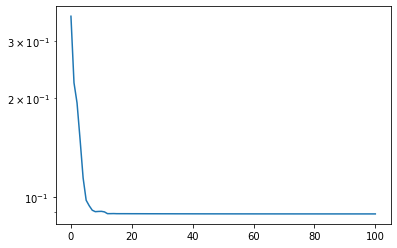

In [507]:
plt.semilogy(Ss)

In [486]:
entanglement_entropy(Psi)

0.15071614721923182

In [ ]:
a = np.ra

In [477]:
%%timeit


23.8 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [478]:
%%timeit
out = series_contraction(As, Lambda)

1.73 s ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [474]:

tn_out = [i.tensor for i in out]
print(mps_overlap(Psi, tn_out))

1.0000000000000322


In [360]:
lambda_shape = [i.shape for i in Lambda]
a_shape = [a.shape for a in A1]

In [448]:
import numpy as np
from copy import deepcopy

a_shape = [(2, 1, 1, 2), (2, 2, 2, 2)]
lambda_shape = [(2, 1, 1, 2), (2, 1, 2, 4)]
A1 = [np.random.rand(*shape) for shape in a_shape]
Lambda = [np.random.rand(*shape) for shape in lambda_shape]
A2 = deepcopy(A1)
Lambda2 = deepcopy(Lambda)
def process_mpos(mpo):
    tn_mpo = [tn.Node(i) for i in mpo]
    for i in range(len(mpo)-1):
        tn_mpo[i][-1] ^ tn_mpo[i+1][2]
    return tn_mpo
import sys
def mpo_on_mpo(mpoL, mpoR):
    L = len(mpoL)
    mpoL[0][1] ^ mpoR[0][2]
    for i in range(L-1):
        mpoL[i+1][1] ^ mpoR[i][0]
    mpoL[L-1][3] ^ mpoR[L-1][0]
    
    edge_list = []
    for i in range(L):
        edge_list.extend(ordered_get_all_dangling([mpoL[i], mpoR[i]]))
    output = tn.contractors.auto(tn.reachable(mpoL[0]), output_edge_order=edge_list)

    return output

def ordered_get_all_dangling(nodes):
    edges = []
    for node in nodes:
        for edge in node.edges:
            if edge.is_dangling():
                edges.append(edge)
    return edges

In [183]:
tn_Psi = mpo_on_mpo(A1, Lambda)
#tn_Psi = mpo_on_mpo(A0, tn_Psi)
tn_Psi = [i.tensor for i in tn_Psi]
tn_Psi = mpo_on_mpo(A0, tn_Psi)
tn_Psi = [i.tensor for i in tn_Psi]

ValueError: Cannot connect edges of unequal dimension. Dimension of edge 'Dangling_1': 1, Dimension of edge 'Dangling_2': 2.

In [90]:
def setup_mpo_network(lenv, renv, mpo):
    all_mpos = [[],[],[]]
    dl =  lenv[0].shape[0]
    L = len(mpo)
    for i in range(L):
        all_mpos[0].append(tn.Node(lenv[i], name=f"lenv_{i}"))
        all_mpos[1].append(tn.Node(mpo[i], name=f"mpo_{i}"))
        all_mpos[2].append(tn.Node(renv[i], name=f"renv_{i}"))
    for i in range(L-1):
        for j in range(3):
            all_mpos[j][i][3] ^ all_mpos[j][i+1][2]
            
    for i in range(1, L):
        all_mpos[0][i][1] ^ all_mpos[1][i-1][0]
        all_mpos[1][i][1] ^ all_mpos[2][i-1][0]
        
    all_mpos[0][L-1][3] ^ all_mpos[1][L-1][0]
    all_mpos[1][L-1][3] ^ all_mpos[2][L-1][0]
    
    all_mpos[0][0][1] ^ all_mpos[1][0][2]
    all_mpos[1][0][1] ^ all_mpos[2][0][2]
    
    return(all_mpos)

def setup_environment(all_mpos, i, mps_left, mps_right):
    """ Removes node i, contracts """
    L = len(mps_left)
    mps_L, all_mpos, mps_R = exp_val_mpo(mps_left, mps_right, all_mpos)
    
    #edge_order = []
    #edge_order.extend([all_mpos[0][i][0] for i in range(L)])
    #edge_order.extend([all_mpos[2][i][1] for i in range(L)])

    #edge_order.append(all_mpos[0][0][2])
    #edge_order.append(all_mpos[2][-1][3])
    
    output = tn.contractors.auto(tn.reachable(all_mpos[0][0]))
    return(output)

In [91]:
def contract_mps(mps):
    t = mps[0]
    d = mps[0].shape[0]
    for i in range(1, len(mps)):
        t = np.tensordot(t, mps[i], [-1, 1])
    return t.reshape([d]*len(mps))

def tensor_overlap(t1, t2):
    assert t1.shape == t2.shape
    return np.tensordot(t1, t2, [range(t1.ndim), range(t2.ndim)])

In [98]:
[i.shape for i in A2]

[(2, 1, 1, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2)]

In [97]:
all_mpos = setup_mpo_network(A0, A2, A1)
out = setup_environment(all_mpos, 0, tebd_state.copy(), mpo2mps(Lambda))

0


ValueError: Cannot connect edges of unequal dimension. Dimension of edge 'Dangling_0': 2, Dimension of edge 'Dangling_1': 1.

In [67]:
output = construct_env(A0, Lambda, A1)
result = output.tensor.reshape([2]*10)

In [68]:
tensor = contract_mps(tebd_state)
tensor_overlap(tensor, result)

array(1.)

In [73]:
tebd_state, _, _ = tebd(10, 1.5, 0.1)
Psi = mps2mpo(tebd_state.copy())
A0, Lambda = diagonal_expansion(Psi)
Lambda = mps_2form(Lambda, 'B')
A1, Lambda = diagonal_expansion(Lambda)
A2, Lambda = diagonal_expansion(Lambda)

out = contract_series_diagonal_expansions([A0, A1, A2], Lambda)
out = mpo2mps(out)
mps_overlap(out, tebd_state)

1.0000000000000056

In [99]:
[i.shape for i in Lambda]

[(2, 1, 1, 2),
 (2, 1, 2, 4),
 (2, 1, 4, 8),
 (2, 1, 8, 16),
 (2, 1, 16, 32),
 (2, 1, 32, 16),
 (2, 1, 16, 8),
 (2, 1, 8, 4),
 (2, 1, 4, 2),
 (2, 1, 2, 1)]

In [ ]:
[i.shape for i in contract_diagonal_expansion(A2, Lambda)]

> /home/t30/pol/ge38huj/Documents/state_approximation/state_approximation.py(319)contract_diagonal_expansion()
-> prod = np.tensordot(A0[i], Lambda[i-1], [1,0])


(Pdb)  A0[i].shape


(2, 2, 2, 2)


In [103]:
[i.shape for i in A2]

[(2, 1, 1, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2),
 (2, 2, 2, 2)]

In [104]:
[i.shape for i in Lambda]

[(2, 1, 1, 2),
 (2, 1, 2, 4),
 (2, 1, 4, 8),
 (2, 1, 8, 16),
 (2, 1, 16, 32),
 (2, 1, 32, 16),
 (2, 1, 16, 8),
 (2, 1, 8, 4),
 (2, 1, 4, 2),
 (2, 1, 2, 1)]